# 第二次讀書會報告

組別:第9組

Date:2024/04/09

# 1.載入環境及安裝套件

In [74]:
# 載入套件
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import jieba
from pprint import pprint
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk import FreqDist
import re
from datetime import datetime
from collections import Counter,namedtuple
from tqdm import tqdm
import math
import networkx as nx

#下載文字雲所需套件
from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

# 下載斷句需要的資源
nltk.download('punkt')
# 下載POS tagger需要的資源
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
#下載停用詞
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/billyke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/billyke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/billyke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/billyke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/billyke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

#圖型相關設定
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

# 2.資料處理

## 2.1 資料蒐集、彙整與處理
本組自Kaggle下載Amazon上有關Finee Food類的評論資料集。
本組自Kaggle下載Amazon上有關Finee Food類的評論資料集。
該資料集包括對來自亞馬遜的精美食品的評論。
這些資料的使用期限超過10年，包括1999年10月至2012年10月
約500,000條評論。評論包括產品和使用者資訊，評級以及純文字評論。
它還包括來自所有其他亞馬遜類別的評論。

Data includes:
*   Reviews from Oct 1999 - Oct 2012
*   568,454 reviews
*   256,059 users
*   74,258 products

資料來源:https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

##### 在讀書會報告一時已進行過資料清理，故此次報告匯入資料為清理過後之資料
其中因為評論分數Score為三分的評論不易定義其情緒分數為正向或負向，故予以剔除

以下為程式碼：

Amazon_df = Amazon_df.copy()

Amazon_df  = Amazon_df [Amazon_df ['Score'] != 3]

清理過後新的資料集筆數為28,605筆，資料期間為1999年到2007年間

In [76]:
# -*- coding: utf-8 -*-
#匯入資料
noStop_Amazon_df = pd.read_csv('./2024_study_group9_2/raw_data/noStop2_en_data.csv')
#剔除評論分數3後的資料
aggregated_df_new = pd.read_csv('./2024_study_group9_2/raw_data/new_score_data.csv')
#資料清理但尚未字詞還原的資料集
MetaData = pd.read_csv('./2024_study_group9_2/raw_data/test_content_df.csv')

In [78]:
aggregated_df_new

,index,aggregated_words,year,score,sentiment_score
0,0,starter antisplenda fanatic user year despite ...,1999,0,positive
1,1,end throw away hummus salty bitter edamame not...,1999,0,negative
2,2,sure someone give star review berry fresh tast...,1999,1,positive
3,3,open bag shipment arrive never berry sure expe...,2000,1,positive
4,4,powder great add mocha flavor baked good easy ...,2000,1,positive
...,...,...,...,...,...
28600,28600,give treat little yorkie two year absolutely l...,2007,0,positive
28601,28601,disagree review love little bit crunch otherwi...,2007,1,positive
28602,28602,buy cookie easter gift two different family me...,2007,1,positive
28603,28603,everyone love pocky say lie lol pocky arrive g...,2007,1,positive


In [80]:
MetaData

,year,score,sentence
0,1999,0,For starters Im not an antiSplenda fanatic Ive...
1,1999,0,I ended up throwing away most of this The humm...
2,1999,1,Im not sure why someone gave this a star revie...
3,2000,1,I just opened a bag of these after my shipment...
4,2000,1,This powder is great for adding a mocha flavor...
...,...,...,...
28600,2007,0,Weve been giving this treat to our little York...
28601,2007,1,I have to disagree with the other review here ...
28602,2007,1,I bought these cookies as Easter gifts for two...
28603,2007,1,Everyone loves Pocky and if they say they dont...


In [82]:
#透過year進行groupby統合
MetaData = MetaData.groupby('year')['sentence'].apply(lambda x:x.str.cat(sep=' ')).reset_index()
MetaData

,year,sentence
0,1999,For starters Im not an antiSplenda fanatic Ive...
1,2000,I just opened a bag of these after my shipment...
2,2001,I love this flavor but it has become hard to c...
3,2002,Because my has a peanut allergy we keep our ho...
4,2003,this is a great productwell made great tastego...
5,2004,My Husky puppy LOVES these They are the perfec...
6,2005,I had this sauce several years ago in a restau...
7,2006,Although it seems like it might cost a little ...
8,2007,This is by far the best protien bar I have tri...


In [83]:
#新增stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')
newStops = ['br', 'would', 'much', 'one','use','also','could','many','amazon']
stopWords.extend(newStops)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/billyke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
# 設定斷詞function，以便之後進行斷詞
stemmer = PorterStemmer() #做Stemming還原詞幹

def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    return seg_list

## 2.2 TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度。
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 )

In [7]:
# 列出各年份的總詞彙數
total_words = noStop_Amazon_df.groupby(['year'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,year,total
0,1999,359
1,2000,1140
2,2001,563
3,2002,4372
4,2003,5275
5,2004,21299
6,2005,52431
7,2006,246065
8,2007,829027


In [8]:
# 計算各詞彙在各年份中出現的次數
word_count = noStop_Amazon_df.groupby(["year","word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,year,word,count
0,1999,add,1
1,1999,adherent,1
2,1999,aftertaste,1
3,1999,aid,1
4,1999,always,1
...,...,...,...
68027,2007,zukes,17
68028,2007,zukesbr,1
68029,2007,zukess,1
68030,2007,zylitor,1


In [10]:
#合併每個詞彙在每個年份中出現的次數與每個年份的總詞數
tp_words = word_count.merge(total_words,on = 'year',how = 'left')
tp_words.head(20)

,year,word,count,total
0,1999,add,1,359
1,1999,adherent,1,359
2,1999,aftertaste,1,359
3,1999,aid,1,359
4,1999,always,1,359
5,1999,antioxidant,1,359
6,1999,antisplenda,1,359
7,1999,appear,2,359
8,1999,apportion,1,359
9,1999,apt,1,359


In [11]:
# 計算tf
tp_words_tf_idf = tp_words.assign(tf = tp_words.iloc[:,2]/tp_words.iloc[:,3])
tp_words_tf_idf.head()

,year,word,count,total,tf
0,1999,add,1,359,0.002786
1,1999,adherent,1,359,0.002786
2,1999,aftertaste,1,359,0.002786
3,1999,aid,1,359,0.002786
4,1999,always,1,359,0.002786


In [12]:
# 計算每個詞彙出現在幾個年份中
idf_df = tp_words.groupby(['word'],as_index=False).size()
tp_words_tf_idf = tp_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
tp_words_tf_idf.head()

,year,word,count,total,tf,size
0,1999,add,1,359,0.002786,8
1,1999,adherent,1,359,0.002786,1
2,1999,aftertaste,1,359,0.002786,7
3,1999,aid,1,359,0.002786,5
4,1999,always,1,359,0.002786,8


In [13]:
# 計算idf
tp_words_tf_idf = tp_words_tf_idf.assign(idf = tp_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

tp_words_tf_idf = tp_words_tf_idf.drop(labels=['size'],axis=1)
tp_words_tf_idf.head()

,year,word,count,total,tf,idf
0,1999,add,1,359,0.002786,0.051153
1,1999,adherent,1,359,0.002786,0.954243
2,1999,aftertaste,1,359,0.002786,0.109144
3,1999,aid,1,359,0.002786,0.255273
4,1999,always,1,359,0.002786,0.051153


In [14]:
# 計算 tf-idf(將tf與idf的值相乘所得之結果)
tp_words_tf_idf = tp_words_tf_idf.assign(tf_idf = tp_words_tf_idf.iloc[:,4] * tp_words_tf_idf.iloc[:,5])
tp_words_tf_idf.head(10)

,year,word,count,total,tf,idf,tf_idf
0,1999,add,1,359,0.002786,0.051153,0.000142
1,1999,adherent,1,359,0.002786,0.954243,0.002658
2,1999,aftertaste,1,359,0.002786,0.109144,0.000304
3,1999,aid,1,359,0.002786,0.255273,0.000711
4,1999,always,1,359,0.002786,0.051153,0.000142
5,1999,antioxidant,1,359,0.002786,0.051153,0.000142
6,1999,antisplenda,1,359,0.002786,0.954243,0.002658
7,1999,appear,2,359,0.005571,0.109144,0.000608
8,1999,apportion,1,359,0.002786,0.653213,0.001820
9,1999,apt,1,359,0.002786,0.352183,0.000981


In [100]:
tp_df = MetaData.copy()

# 需要改成使用空格連接斷好的詞
tp_df['word'] = tp_df.sentence.apply(getToken).map(' '.join)
tp_df.head()

,year,sentence,word
0,1999,For starters Im not an antiSplenda fanatic Ive...,starter im antisplenda fanat ive user year des...
1,2000,I just opened a bag of these after my shipment...,open bag shipment arriv never berri sure expec...
2,2001,I love this flavor but it has become hard to c...,love flavor becom hard come groceri store star...
3,2002,Because my has a peanut allergy we keep our ho...,becaus peanut allergi keep home nutfre got cak...
4,2003,this is a great productwell made great tastego...,great productwel made great tastegood packagin...


In [101]:
# Bag of Word(詞袋分析)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tp_df['word'])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray(),)
DTM_df

,aa,aaaa,aaaaaaaaaaaaaaa,aaaaaaahhhhhh,aaaaaawwwwwwwwww,aaaahhhhhh,aaah,aaahhhhhh,aaf,aafco,...,zridg,zsweet,zucchini,zuke,zukebr,zukesbr,zukess,zylitor,zzz,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
6,1,0,0,1,1,0,0,0,1,0,...,0,0,0,3,0,1,0,0,0,1
7,0,0,1,0,0,0,0,1,0,3,...,1,0,3,20,0,0,0,0,0,0
8,6,1,0,0,0,1,1,0,0,2,...,0,7,6,46,1,1,1,1,1,0


此部分出現aaa,aaaahhhhhh等詞彙,為真實存在評論,
即客人在評論中輸入似狀聲詞或誤按等其他因素而存在的字詞,之後的dataframe數據也是同樣原因
但因其佔的比例極低,故對本研究影響不大

In [90]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,aa,aaaa,aaaaaaaaaaaaaaa,aaaaaaahhhhhh,aaaaaawwwwwwwwww,aaaahhhhhh,aaah,aaahhhhhh,aaf,aafco,...,zridg,zsweet,zucchini,zuke,zukebr,zukesbr,zukess,zylitor,zzz,zzzzzz
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.001880,0.001661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000889,0.000000,0.000000,0.001052,0.001052,0.000000,0.000000,0.000000,0.001052,0.000000,...,0.000000,0.00000,0.000000,0.002048,0.000000,0.000889,0.000000,0.000000,0.000000,0.001052
7,0.000000,0.000000,0.000224,0.000000,0.000000,0.000000,0.000000,0.000224,0.000000,0.000567,...,0.000224,0.00000,0.000493,0.002906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000340,0.000067,0.000000,0.000000,0.000000,0.000067,0.000067,0.000000,0.000000,0.000113,...,0.000000,0.00047,0.000296,0.002002,0.000067,0.000057,0.000067,0.000067,0.000067,0.000000


### 根據tfidf值來挑出重要詞彙的方法有許多種，以下採用兩個方法進行比較：

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [91]:
tp_tfidf = TFIDF_df.mean().to_frame().reset_index()
tp_tfidf.columns = ["word", "avg"]

tp_tfidf.sort_values('avg', ascending = False).head(20)

,word,avg
29429,tast,0.211387
16760,like,0.207912
12496,good,0.174662
5762,coffe,0.159294
10897,flavor,0.156136
29581,tea,0.148104
17138,love,0.140024
30863,tri,0.136380
23283,product,0.132215
12810,great,0.124997


由結果可知,依然能順利計算出詞頻,不會受到上述所提之字詞影響
此為方法1選出的重要詞彙

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [192]:
toptens = TFIDF_df.copy()
toptens.insert(0,'Year' ,toptens.index+1)


0.0

In [115]:
#id_vars: 可使用 tuple、list、或 ndarray，用以設定不想要被轉換的欄位。
#var_name : 轉換後 id 的名稱。如果省略則設定為原本 DataFrame 的欄位名稱或是 variable。
#value_name : 轉換後 value 欄位的名稱。如果省略則顯示原本 DataFrame 的欄位名稱或 value。

toptens = toptens.melt(id_vars = "Year", var_name = "word", value_name = 'tfidf')
toptens

,Year,word,tfidf
0,1,aa,0.000000
1,2,aa,0.000000
2,3,aa,0.000000
3,4,aa,0.000000
4,5,aa,0.000000
...,...,...,...
306814,5,zzzzzz,0.000000
306815,6,zzzzzz,0.000000
306816,7,zzzzzz,0.001052
306817,8,zzzzzz,0.000000


In [117]:
(
 # 從每個章節挑選出tf-idf最大的前十個詞
    toptens.groupby("Year").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
 # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(20) # 排序看前二十名

,word,size
16,like,8
12,good,8
26,tast,8
27,tea,6
7,flavor,6
30,tri,6
23,product,6
17,love,6
3,coffe,5
8,food,4


此為方法2選出的重要詞彙,可以看出與方法1有所不同

## 2.3 斷詞與N-gram
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
此部分本小組採用bigram與trigram。

### 2.3.1 Bigram

In [118]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    #選出2個關聯詞彙
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [119]:
tp_bigram = MetaData.copy()
tp_bigram["word"] = tp_bigram.sentence.apply(bigram_getToken)
tp_bigram = tp_bigram.explode('word')
tp_bigram

,year,sentence,word
0,1999,For starters Im not an antiSplenda fanatic Ive...,starter im
0,1999,For starters Im not an antiSplenda fanatic Ive...,im antisplenda
0,1999,For starters Im not an antiSplenda fanatic Ive...,antisplenda fanat
0,1999,For starters Im not an antiSplenda fanatic Ive...,fanat ive
0,1999,For starters Im not an antiSplenda fanatic Ive...,ive user
...,...,...,...
8,2007,This is by far the best protien bar I have tri...,make life
8,2007,This is by far the best protien bar I have tri...,life fulfil
8,2007,This is by far the best protien bar I have tri...,fulfil im
8,2007,This is by far the best protien bar I have tri...,im fairli


In [120]:
# 計算每個組合出現的次數
tp_bigram_count = tp_bigram.groupby(["word"],as_index=False).size()
tp_bigram_count.sort_values(by=['size'], ascending=False).head(15)

,word,size
456591,tast like,1455
220331,highli recommend,1044
207557,groceri store,814
456339,tast great,805
206419,green tea,737
456309,tast good,732
334767,peanut butter,694
130597,dog food,688
196029,gluten free,632
242261,ive tri,627


### 2.3.2 trigram

In [121]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    #選出3個關聯詞彙
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [122]:
tp_trigram = MetaData.copy()
tp_trigram["word"] = tp_trigram.sentence.apply(trigram_getToken)
tp_trigram = tp_trigram.explode('word')
tp_trigram

,year,sentence,word
0,1999,For starters Im not an antiSplenda fanatic Ive...,starter im antisplenda
0,1999,For starters Im not an antiSplenda fanatic Ive...,im antisplenda fanat
0,1999,For starters Im not an antiSplenda fanatic Ive...,antisplenda fanat ive
0,1999,For starters Im not an antiSplenda fanatic Ive...,fanat ive user
0,1999,For starters Im not an antiSplenda fanatic Ive...,ive user year
...,...,...,...
8,2007,This is by far the best protien bar I have tri...,world make life
8,2007,This is by far the best protien bar I have tri...,make life fulfil
8,2007,This is by far the best protien bar I have tri...,life fulfil im
8,2007,This is by far the best protien bar I have tri...,fulfil im fairli


In [124]:
# 計算每個組合出現的次數
tp_trigram_count = tp_trigram.groupby(["word"],as_index=False).size()
tp_trigram_count.sort_values(by=['size'], ascending=False).head(15)

,word,size
492585,local groceri store,204
404310,highli recommend product,121
395407,health food store,118
402826,high fructos corn,89
334581,fructos corn syrup,83
358126,goe long way,83
845068,thi great product,79
115415,cant go wrong,77
505169,love love love,74
116029,cant wait tri,74


## 3. bigram視覺化相關圖繪製

In [125]:
#根據剛剛的觀察可以增加stopwords
stopWords.extend(['im', 'ive'])

In [126]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [127]:
fud_bigram2 = MetaData.copy()
fud_bigram2["word"] = fud_bigram2.sentence.apply(bigram_getToken_dict)
fud_bigram2 = fud_bigram2.explode('word')
fud_bigram2.head(3)

,year,sentence,word
0,1999,For starters Im not an antiSplenda fanatic Ive...,starter antisplenda
0,1999,For starters Im not an antiSplenda fanatic Ive...,antisplenda fanat
0,1999,For starters Im not an antiSplenda fanatic Ive...,fanat user


In [128]:
# 看一下bigramfdist內容
bigramfdist.most_common(10)

[(('tast', 'like'), 1455),
 (('highli', 'recommend'), 1044),
 (('groceri', 'store'), 814),
 (('tast', 'great'), 805),
 (('green', 'tea'), 737)]

In [129]:
# 建立bigram和count的dictionary
# 這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(20)}
d

{('tast', 'like'): 1455,
 ('highli', 'recommend'): 1044,
 ('groceri', 'store'): 814,
 ('tast', 'great'): 805,
 ('green', 'tea'): 737,
 ('tast', 'good'): 732,
 ('peanut', 'butter'): 694,
 ('dog', 'food'): 688,
 ('gluten', 'free'): 632,
 ('cat', 'food'): 592,
 ('year', 'old'): 582,
 ('dog', 'love'): 581,
 ('thi', 'product'): 562,
 ('cup', 'coffe'): 548,
 ('realli', 'like'): 548,
 ('dont', 'know'): 508,
 ('great', 'product'): 496,
 ('great', 'tast'): 456,
 ('realli', 'good'): 452,
 ('tea', 'bag'): 421,
 ('first', 'time'): 396,
 ('subscrib', 'save'): 385,
 ('thi', 'great'): 380,
 ('dont', 'like'): 369,
 ('year', 'ago'): 366,
 ('hard', 'find'): 355,
 ('look', 'like'): 335,
 ('local', 'store'): 330,
 ('everi', 'day'): 322,
 ('even', 'though'): 319}

In [130]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.05 for w in  G.edges(data=True)]

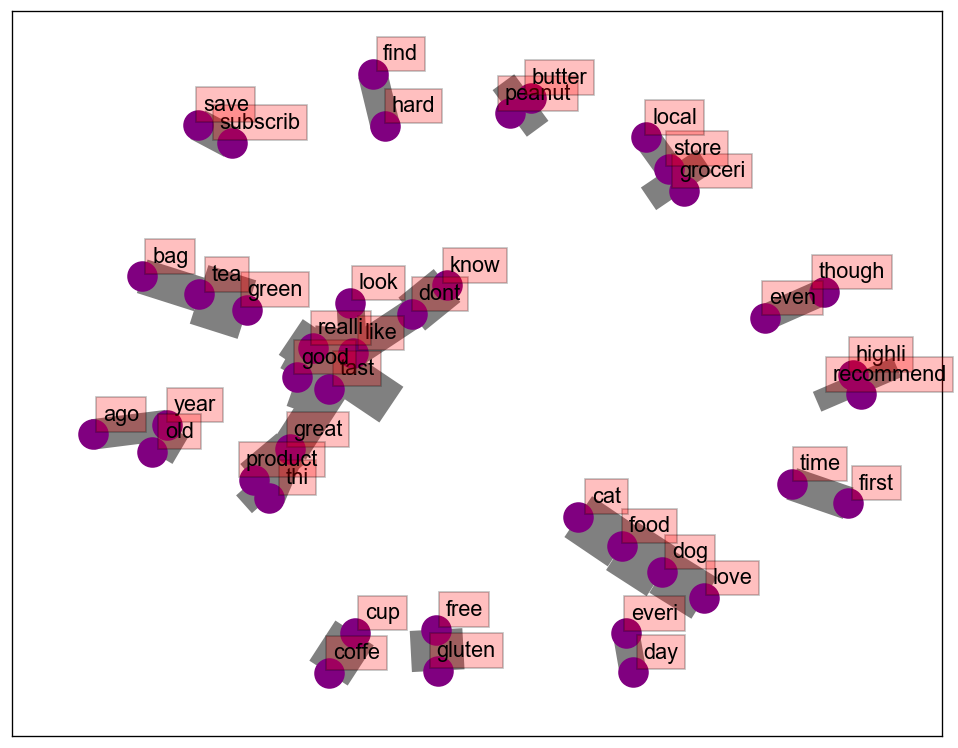

In [131]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

#### 透過network plot圖可以發現詞之間的關聯性如green tea表示綠茶可能是很常被談論的商品,
#### coffee cup有可能評論上很常提及咖啡杯或是享用一杯咖啡的感覺,
#### cat 與 dog love food可能與寵物食品有關,其商品可能同時銷售給有養貓狗的人士,
#### 而find hard則可能與負評有關,表示客人可能在找尋想要的商品時有困難,可能與Amazon商品設置或行銷執行成效不彰所導致,
#### 以上皆可做為Amazon行銷與商業策略的參考依據。

# 4. Pairwise correlation

In [132]:
#計算兩個詞彙間的相關性 Pearson correlation
data_cor = MetaData.copy()

#需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor

,year,sentence,word
0,1999,For starters Im not an antiSplenda fanatic Ive...,starter antisplenda fanat user year despit int...
1,2000,I just opened a bag of these after my shipment...,open bag shipment arriv never berri sure expec...
2,2001,I love this flavor but it has become hard to c...,love flavor becom hard come groceri store star...
3,2002,Because my has a peanut allergy we keep our ho...,becaus peanut allergi keep home nutfre got cak...
4,2003,this is a great productwell made great tastego...,great productwel made great tastegood packagin...
5,2004,My Husky puppy LOVES these They are the perfec...,huski puppi love perfect size train even thoug...
6,2005,I had this sauce several years ago in a restau...,sauc sever year ago restaur buy ever sinc spic...
7,2006,Although it seems like it might cost a little ...,although seem like might cost littl get indivi...
8,2007,This is by far the best protien bar I have tri...,thi far best protien bar tri tri alota href nu...


In [133]:
# Bag of Word
# 篩選至少出現在5年評論以上且詞頻前1500的詞彙

vectorizer = CountVectorizer(min_df = 5, max_features = 1500)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,abl,absolut,actual,ad,add,ago,almost,alway,amaz,amount,...,went,white,whole,wish,without,wonder,wont,work,worth,year
0,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1
1,2,0,0,2,5,2,0,0,1,0,...,3,2,1,1,3,3,1,1,2,6
2,0,0,0,0,0,0,1,1,0,1,...,0,2,0,0,0,2,0,1,1,1
3,2,3,10,5,4,2,2,6,1,3,...,1,7,1,1,7,3,1,10,5,12
4,0,3,3,7,5,4,5,15,4,5,...,8,1,3,3,8,9,3,12,2,12
5,16,14,25,22,40,13,18,27,14,11,...,17,10,29,8,41,35,21,31,25,62
6,39,41,71,65,96,43,47,80,33,50,...,34,36,68,43,83,68,39,89,50,151
7,170,195,353,293,429,141,227,418,151,268,...,218,163,308,182,388,349,213,538,242,664
8,618,691,1150,937,1360,530,852,1357,572,785,...,520,513,1100,562,1330,1139,730,1783,796,2143


In [135]:
# 計算詞之間的相關係數
import numpy as np
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,abl,absolut,actual,ad,add,ago,almost,alway,amaz,...,went,white,whole,wish,without,wonder,wont,work,worth,year
0,abl,1.000000,0.999929,0.999456,0.999303,0.999226,0.999757,0.999903,0.999352,0.999894,...,0.990342,0.999086,0.999975,0.998659,0.999853,0.999494,0.999780,0.999446,0.999600,0.999438
1,absolut,0.999929,1.000000,0.999700,0.999564,0.999438,0.999587,0.999866,0.999665,0.999806,...,0.991401,0.999388,0.999964,0.999017,0.999924,0.999697,0.999888,0.999740,0.999745,0.999627
2,actual,0.999456,0.999700,1.000000,0.999949,0.999890,0.998840,0.999177,0.999942,0.999040,...,0.994184,0.999918,0.999596,0.999685,0.999814,0.999917,0.999798,0.999901,0.999941,0.999941
3,ad,0.999303,0.999564,0.999949,1.000000,0.999963,0.998778,0.998963,0.999929,0.998838,...,0.994685,0.999917,0.999478,0.999850,0.999728,0.999894,0.999679,0.999788,0.999889,0.999976
4,add,0.999226,0.999438,0.999890,0.999963,1.000000,0.998648,0.998796,0.999833,0.998689,...,0.994943,0.999867,0.999405,0.999812,0.999687,0.999886,0.999637,0.999669,0.999896,0.999977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,wonder,0.999494,0.999697,0.999917,0.999894,0.999886,0.998841,0.999246,0.999926,0.999145,...,0.994129,0.999726,0.999662,0.999528,0.999879,1.000000,0.999902,0.999878,0.999967,0.999926
296,wont,0.999780,0.999888,0.999798,0.999679,0.999637,0.999183,0.999651,0.999786,0.999579,...,0.992611,0.999475,0.999881,0.999121,0.999963,0.999902,1.000000,0.999852,0.999900,0.999755
297,work,0.999446,0.999740,0.999901,0.999788,0.999669,0.998722,0.999335,0.999941,0.999181,...,0.993731,0.999713,0.999598,0.999413,0.999776,0.999878,0.999852,1.000000,0.999830,0.999754
298,worth,0.999600,0.999745,0.999941,0.999889,0.999896,0.998991,0.999302,0.999866,0.999210,...,0.993792,0.999774,0.999725,0.999511,0.999916,0.999967,0.999900,0.999830,1.000000,0.999949


In [141]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=True).head(30)

,word1,word2,cor
70490,went,sauc,0.979950
87234,sauc,went,0.979950
87051,chicken,went,0.980106
15590,went,chicken,0.980106
87213,protein,went,0.982288
64190,went,protein,0.982288
60590,went,piec,0.982863
87201,piec,went,0.982863
12234,sauc,candi,0.983175
70240,candi,sauc,0.983175


In [142]:
d_sum = word_cor_df[(word_cor_df["word1"]=="protein")].sort_values(by=['cor'], ascending = False).head(8)
m_sum = word_cor_df[(word_cor_df["word1"]=="food")].sort_values(by=['cor'], ascending = False).head(8)

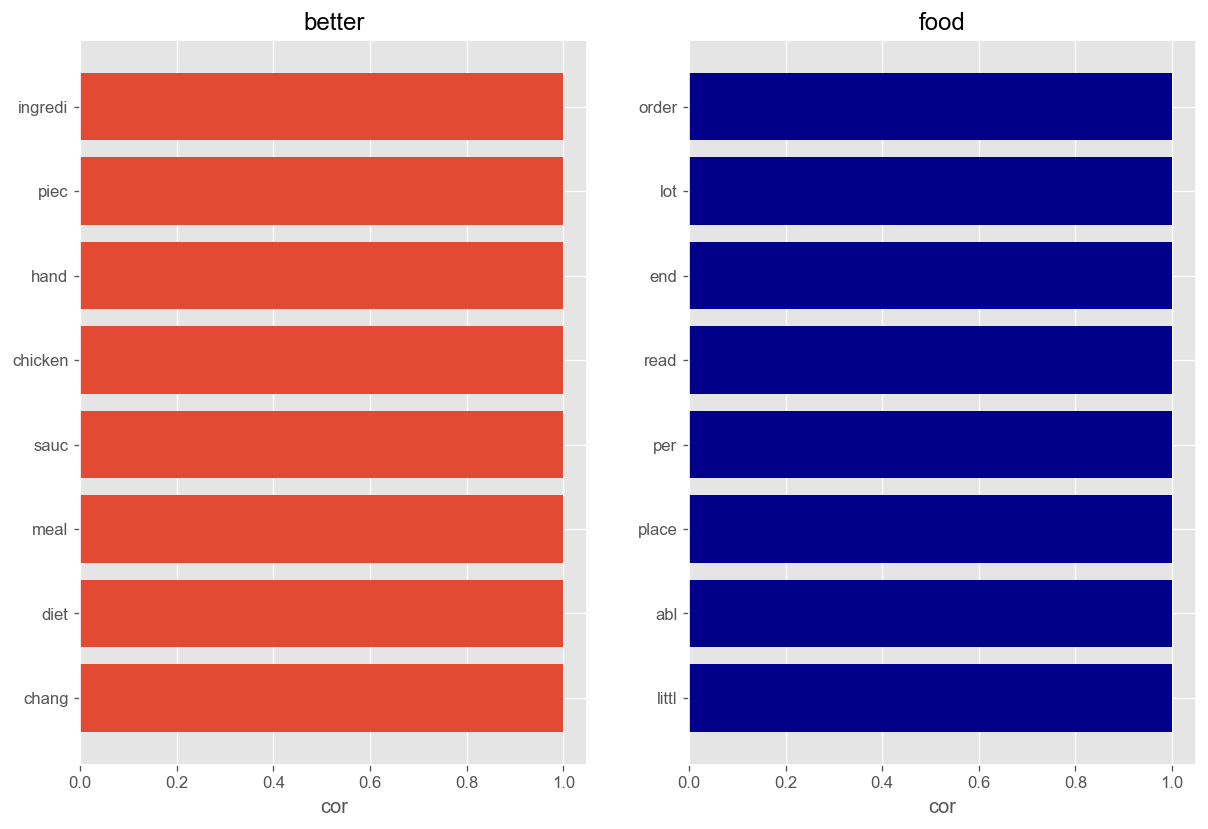

In [143]:
d_sum = d_sum.sort_values(by=['cor'])
m_sum = m_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('better')
plt.xlabel('cor')
plt.barh(d_sum['word2'],d_sum['cor'])

plt.subplot(122)
plt.title('food')
plt.xlabel('cor')
plt.barh(m_sum['word2'],m_sum['cor'],color="darkblue")

plt.show()

以上結果可能原因為：因為大家回覆相近,故每個字的相關性很高,使得相關係數也受到影響

#  5. 分類模型的訓練

## 5.1 根據7:3的比例切分資料集
此部分本小組將整理好的資料集採用30%為訓練資料,70%為測試資料,以此來預測評論文為正向或負向是否準確

In [144]:
#aggregated_df_new

,index,aggregated_words,year,score,sentiment_score
0,0,starter antisplenda fanatic user year despite ...,1999,0,positive
1,1,end throw away hummus salty bitter edamame not...,1999,0,negative
2,2,sure someone give star review berry fresh tast...,1999,1,positive
3,3,open bag shipment arrive never berry sure expe...,2000,1,positive
4,4,powder great add mocha flavor baked good easy ...,2000,1,positive
...,...,...,...,...,...
28600,28600,give treat little yorkie two year absolutely l...,2007,0,positive
28601,28601,disagree review love little bit crunch otherwi...,2007,1,positive
28602,28602,buy cookie easter gift two different family me...,2007,1,positive
28603,28603,everyone love pocky say lie lol pocky arrive g...,2007,1,positive


In [146]:
# aggregated_df_new["score"] = aggregated_df_new["score"].astype('str')
# aggregated_df_new["score"] = aggregated_df_new["score"].replace(['0'],'negative')
# aggregated_df_new["score"] = aggregated_df_new["score"].replace(['1'],'positive')
# aggregated_df_new["score"]

In [154]:
data = aggregated_df_new.copy()
X = data["aggregated_words"]
y = data["sentiment_score"]

# 把整個資料集以70%與30%切分,並採用隨機的方式
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

X_train.head()

22874    order subscribe save save extra make price che...
21651    dog love food live rural area make easy buy th...
1312     product convienent buy small jar grocery store...
22064    drink tea daily least year want hot drink eat ...
27311    good product easily catch kill outdoor fly sum...
Name: aggregated_words, dtype: object

In [155]:
y_train.head()

22874    positive
21651    positive
1312     positive
22064    positive
27311    negative
Name: sentiment_score, dtype: object

In [157]:
#各個資料集切分的比例，應該要一致,故此處做個驗證
print(
    f"raw data percentage :\n{data['sentiment_score'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
positive    91.113442
negative     8.886558
Name: sentiment_score, dtype: float64

train percentage :
positive    91.100235
negative     8.899765
Name: sentiment_score, dtype: float64

test percentage :
positive    91.144255
negative     8.855745
Name: sentiment_score, dtype: float64


## 5.2 將評論轉為 DTM
以下採用2種方法：

(1)依據詞頻 (classic BoW)

   用 CountVectorizer()

(2)依據tfidf (advanced variant of BoW),篩選出現次數大於10的字

   用 TfidfVectorizer()

常用參數介紹
max_features: 取 詞頻 / tfidf 前多少的字

第1種方法：依據詞頻 (classic BoW)

In [160]:
# vectorizer
vectorizer = CountVectorizer(max_features=3000, stop_words="english")
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_test = vectorizer.transform(X_test)

# classifier,因LogisticRegression會產生迭代問題,故設定max_iter=3000
clf = LogisticRegression(max_iter=3000)
clf.fit(vec_train, y_train)

y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

In [161]:
#呈現出Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.74      0.61      0.67       760
    positive       0.96      0.98      0.97      7822

    accuracy                           0.95      8582
   macro avg       0.85      0.79      0.82      8582
weighted avg       0.94      0.95      0.94      8582



(array([0.5, 1.5]), [Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')])

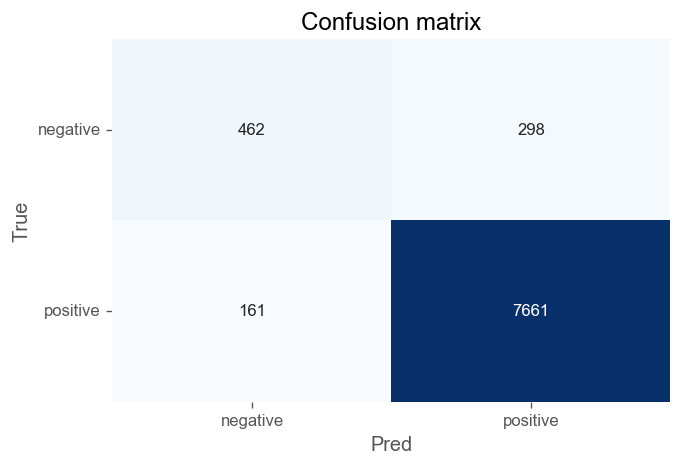

In [162]:
#此部分為呈現出混肴矩陣,除了可評估預測結果,還能看出分類器的成效

classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)

## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

第2種方法：依據tfidf (advanced variant of BoW)

In [163]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.28      0.43       760
    positive       0.93      1.00      0.96      7822

    accuracy                           0.93      8582
   macro avg       0.91      0.64      0.70      8582
weighted avg       0.93      0.93      0.92      8582



由此可知,第一種方法的準確率(0.95)高於第二種方法(0.93)

## 5.3 cross validation-模型驗證

用於評估模型狀態好壞,

為了避免模型對於我們所切的驗證集過度擬合，因此可已透過交叉驗證的方法對模型做更好的評估

              precision    recall  f1-score   support

    negative       0.68      0.51      0.59      1782
    positive       0.95      0.98      0.97     18241

    accuracy                           0.94     20023
   macro avg       0.82      0.74      0.78     20023
weighted avg       0.93      0.94      0.93     20023



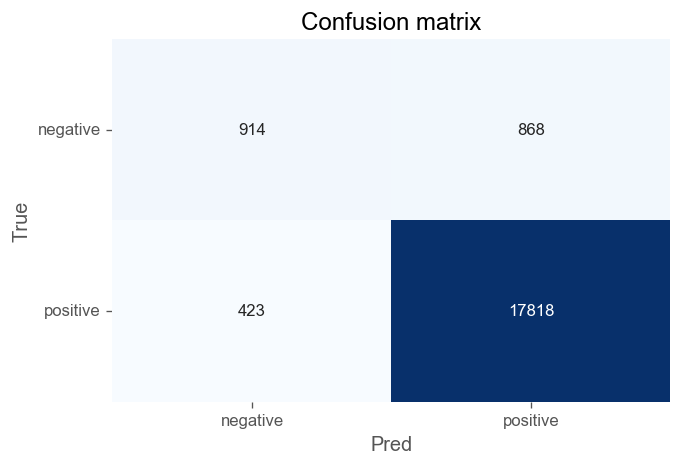

In [172]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results,cv為交叉驗證次數
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    # one-hot encoding
    #enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(y.values.reshape(-1, 1))
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
clf = LogisticRegression(max_iter=3000)
result = train_cv(vectorizer, clf, X_train, y_train)

交叉驗證可知模型準確率為0.94

此部分為建立不同模型訓練組合之分類器,如Logistic,DecisionTree,SVM與RandomForest

now training: clf_logistic
              precision    recall  f1-score   support

    negative       0.68      0.51      0.59      1782
    positive       0.95      0.98      0.97     18241

    accuracy                           0.94     20023
   macro avg       0.82      0.74      0.78     20023
weighted avg       0.93      0.94      0.93     20023

now training: clf_dtree
              precision    recall  f1-score   support

    negative       0.48      0.47      0.48      1782
    positive       0.95      0.95      0.95     18241

    accuracy                           0.91     20023
   macro avg       0.72      0.71      0.71     20023
weighted avg       0.91      0.91      0.91     20023

now training: clf_svm
              precision    recall  f1-score   support

    negative       0.89      0.12      0.21      1782
    positive       0.92      1.00      0.96     18241

    accuracy                           0.92     20023
   macro avg       0.91      0.56      0.59     20023
w

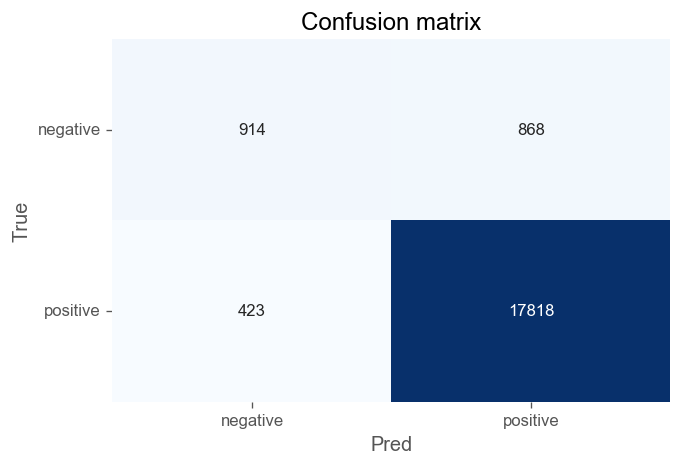

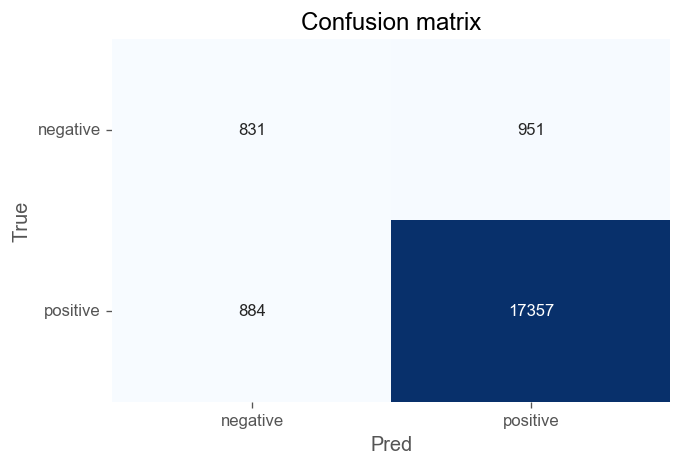

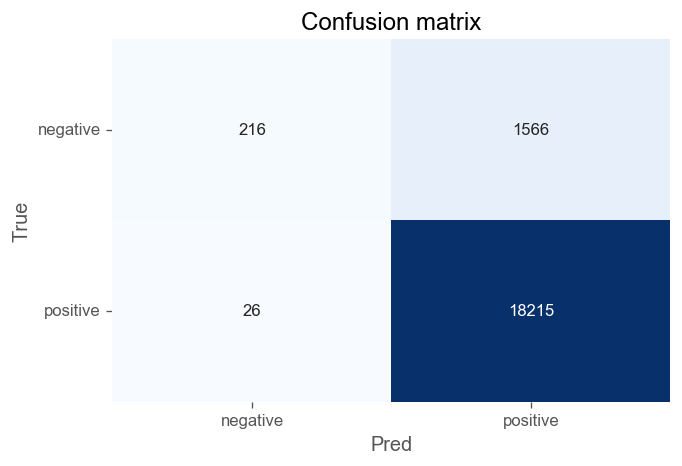

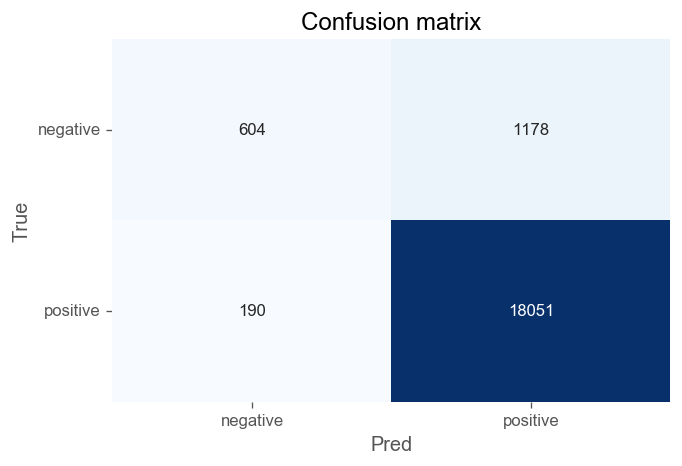

In [174]:
# 準備訓練資料
#data = aggregated_df_new.copy()
X = data["aggregated_words"]
y = data["sentiment_score"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split（
    X, y, test_size=0.3, random_state=777
）
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression(max_iter=3000)
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) #要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

由以上結果可得知四種不同模型的precision,recall,f1-score,confusion_matrix及分類器成效

In [175]:
#此部分為找出最佳模型,由結果可知本次研究最適模型應為LogisticRegression
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")

best model: clf_logistic


In [176]:
#用logistic執行預測並顯示出結果
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.67      0.55      0.60       760
    positive       0.96      0.97      0.97      7822

    accuracy                           0.94      8582
   macro avg       0.81      0.76      0.78      8582
weighted avg       0.93      0.94      0.93      8582



以下為透過係數增加或減少,找出對於正向情緒類別影響力最大前10大影響力字詞,並以繪圖呈現

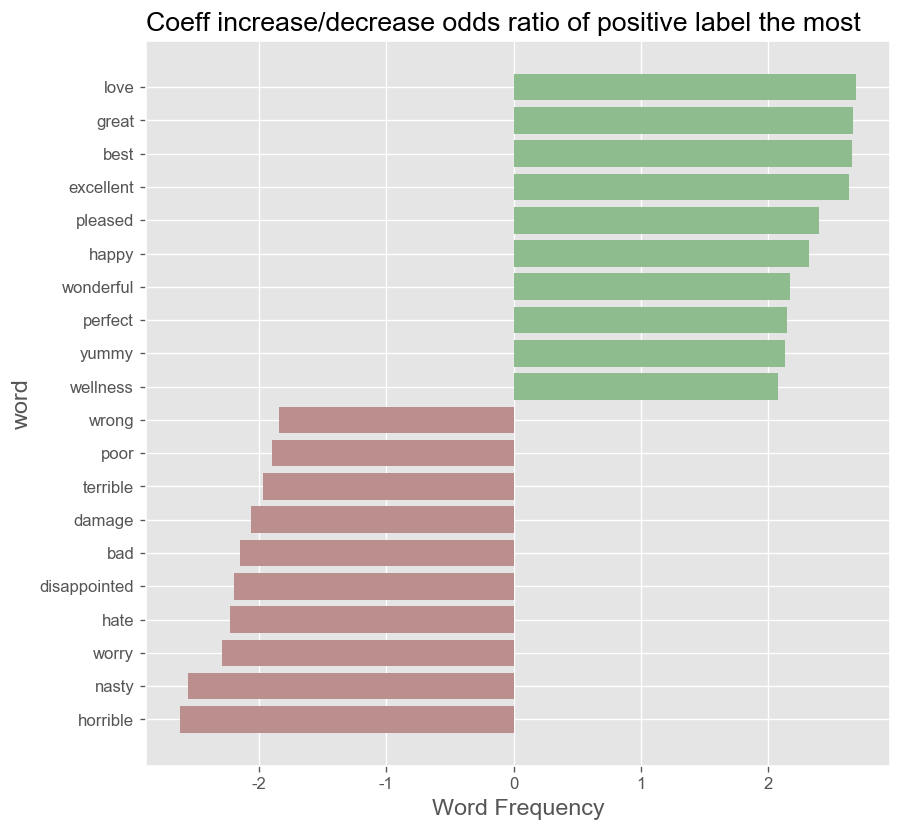

In [177]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_[[1]], index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of " + label + " label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

# plot logistic model
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)